In [53]:
!pip install ultralytics efficientnet_pytorch --quiet

In [54]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from PIL import Image

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch.nn import functional as F
import os
import cv2
from tqdm.notebook import tqdm
import pickle

from torchvision import datasets, models, transforms
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report

from ultralytics import YOLO
from transformers import ViTForImageClassification

# **YOLO**

In [55]:
def get_model_yolo(path_weights_yolo):
    return YOLO(path_weights_yolo, task='detect')

In [56]:
def predict_model_yolo_image(model, img_array):
    results = []
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'    
    with torch.no_grad():
        for image in img_array:
            predict = model(image, save=False, stream=True, verbose=False, device=device)
            for res in predict:
                results.append(res)
    return results

In [57]:
def predict_model_yolo(model, path_data):
    results = []
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        for photo_name in tqdm(os.listdir(path_data)):
            if photo_name[-3:] == 'csv':
                continue
            predict = model([path_data + '/' + photo_name],
                      save=False, stream=True, verbose=False, device=device)
            for res in predict:
                results.append(res)
    return results

In [58]:
def crop_photo_inplace(results_from_model_yolo, padding_percent=0.4):
    for i, result in enumerate(results_from_model_yolo):
        area_detect, box_detect = 0, []
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = box
            if (x2 - x1) * (y2 - y1) > area_detect:
                box_detect = box
        if len(box_detect):
            x1, y1, x2, y2 = map(int, box_detect)
            if padding_percent > 0:
                pad_x, pad_y = (x2 - x1) * padding_percent / 2, (y2 - y1) * padding_percent / 2
                x1 = max(0, x1 - pad_x)
                x2 = min(result.orig_img.shape[1], x2 + pad_x)
                y1 = max(0, y1 - pad_y)
                y2 = min(result.orig_img.shape[0], y2 + pad_y)
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            results_from_model_yolo[i].orig_img = cv2.cvtColor(result.orig_img[y1:y2, x1:x2], cv2.COLOR_BGR2RGB)
    return results_from_model_yolo    

In [59]:
def yolo_step(data, path_yolo):
    model_yolo = get_model_yolo(path_yolo)
    if isinstance(data, str):
        res = predict_model_yolo(model_yolo, data)
    else:
        res = predict_model_yolo_image(model_yolo, data)
    crop_photo_inplace(res, 0)
    return res

# **Classification**

In [60]:
class TestDataset(Dataset):
    def __init__(self, result, transform=None):
        self.result = result
        self.transform = transform

    def __len__(self):
        return len(self.result)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.result[idx].orig_img
        path = self.result[idx].path
        
        if self.transform:
            img_name = self.transform(img_name)

        return img_name, path

In [61]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

In [62]:
def get_model_resnet(path_weights_resnet):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#     model = models.resnet152(pretrained=False)
    with open(path_weights_resnet, 'rb') as f:
        model = torch.load(path_weights_resnet, map_location=device)
    model = model.to(device)
    return model

In [63]:
def get_model_vit(path_weights_vit):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'    
    with open(path_weights_vit, 'rb') as f:
        model = torch.load(path_weights_vit, map_location=device)
    model = model.to(device)
    return model

In [64]:
def get_model_effnet(path_weights_effnet):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'    
    with open(path_weights_effnet, 'rb') as f:
        model = torch.load(path_weights_effnet, map_location=device)
    model = model.to(device)
    return model

In [65]:
def predict_model_classification(model, dataloader, name=""):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.eval()
    pred, pred_path, pred_proba = [], [], []
    for x_batch, x_path in dataloader:
        x_batch = x_batch.to(device)
        if name == "vit":
            outp = model(x_batch).logits
        else:
            outp = model(x_batch)
        proba = F.softmax(outp, dim=1)
        pred_path += list(x_path)
        pred += list(outp.cpu().detach().numpy().argmax(1))
        pred_proba += list(proba.cpu().detach().numpy())
    return pred, pred_path, pred_proba

In [66]:
def resnet_step(path_resnet, dataloader):
    model_resnet = get_model_resnet(path_resnet)
    predict, path, proba = predict_model_classification(model_resnet, dataloader)
    return predict, path, proba

In [67]:
def vit_step(path_vit, dataloader):
    model_vit = get_model_vit(path_vit)
    predict, path, proba = predict_model_classification(model_vit, dataloader, name='vit')
    return predict, path, proba

In [68]:
def effnet_step(path_effnet, dataloader):
    model_effnet = get_model_effnet(path_effnet)
    predict, path, proba = predict_model_classification(model_effnet, dataloader)
    return predict, path, proba

In [69]:
def make_mean(result):
    col = result.columns
    proba_col = col[col.str.startswith('proba')]
    
    def mean_proba(row):
        return row[proba_col].mean()
    result['mean_proba'] = result.apply(mean_proba,axis=1)
    result['pred_mean'] = result['mean_proba'].map(lambda x: x.argmax())
    
    return result

In [70]:
def make_predict(data,         # путь до папки с фото или фото
                 path_yolo,        # YoLo v8  - детекция
                 path_resnet=None,
                 path_vit=None,
                 path_effnet=None):
    
    result = yolo_step(data, path_yolo)
#     return result
    test_dataset = TestDataset(result, data_transforms)
    test_daloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=3)
    
    predict = pd.DataFrame()
    predict['pred_yolo'] = [photo.boxes.cls.mode()[0].item() if photo.boxes.cls.numel() != 0 else np.nan for photo in result]
                   
    if path_resnet:
        predict_resnet, path_resnet, proba_resnet = resnet_step(path_resnet, test_daloader)
        predict['pred_resnet'] = predict_resnet
        predict['path_resnet'] = path_resnet
        predict['proba_resnet'] = proba_resnet
    
    if path_vit:
        predict_vit, path_vit, proba_vit = vit_step(path_vit, test_daloader)
        predict['pred_vit'] = predict_vit
        predict['path_vit'] = path_vit
        predict['proba_vit'] = proba_vit
        
    if path_effnet:
        predict_effnet, path_effnet, proba_effnet = effnet_step(path_effnet, test_daloader)
        predict['pred_effnet'] = predict_effnet
        predict['path_effnet'] = path_effnet
        predict['proba_effnet'] = proba_effnet
        
    predict = make_mean(predict)
    predict['yolo+mean'] = predict.apply(lambda x: x['pred_yolo'] if x['pred_yolo'] in [0., 1., 2.] else x['pred_mean'], axis=1)
    
    return predict

In [71]:
res = make_predict(data='/kaggle/input/parnokopit/test',
                   path_yolo='/kaggle/input/model-weights-cp/yolov8_best.pt',
                   path_resnet='/kaggle/input/model-weights-cp/resnet_crop_best.pth',
                   path_vit='/kaggle/input/model-weights-cp/vit_small_model_full.pth',
                   path_effnet='/kaggle/input/model-weights-cp/EfficientNet_crop_best.pth')

  0%|          | 0/248 [00:00<?, ?it/s]

In [72]:
res

,pred_yolo,pred_resnet,path_resnet,proba_resnet,pred_vit,path_vit,proba_vit,pred_effnet,path_effnet,proba_effnet,mean_proba,pred_mean,yolo+mean
0,0.0,0,/kaggle/input/parnokopit/test/-__303_jpg.rf.ff...,"[0.6181909, 0.031260524, 0.3505486]",0,/kaggle/input/parnokopit/test/-__303_jpg.rf.ff...,"[0.9359661, 0.008951617, 0.055082355]",0,/kaggle/input/parnokopit/test/-__303_jpg.rf.ff...,"[0.982621, 0.00022352481, 0.017155495]","[0.8455927, 0.013478555, 0.14092882]",0,0.0
1,NaN,1,/kaggle/input/parnokopit/test/-8_JPG.rf.b80be6...,"[0.26060712, 0.67609715, 0.06329571]",0,/kaggle/input/parnokopit/test/-8_JPG.rf.b80be6...,"[0.7985048, 0.06548115, 0.13601407]",2,/kaggle/input/parnokopit/test/-8_JPG.rf.b80be6...,"[0.05666986, 0.030856142, 0.912474]","[0.37192726, 0.25747815, 0.3705946]",0,0.0
2,2.0,2,/kaggle/input/parnokopit/test/Im_0002422_jpg.r...,"[0.022649053, 0.0023480454, 0.9750029]",2,/kaggle/input/parnokopit/test/Im_0002422_jpg.r...,"[0.019898761, 0.032232486, 0.9478688]",2,/kaggle/input/parnokopit/test/Im_0002422_jpg.r...,"[8.478396e-06, 4.4982468e-07, 0.99999106]","[0.014185431, 0.011526994, 0.97428757]",2,2.0
3,0.0,2,/kaggle/input/parnokopit/test/tr64a_MuskDeer_2...,"[0.08172398, 0.08517256, 0.8331034]",0,/kaggle/input/parnokopit/test/tr64a_MuskDeer_2...,"[0.8268217, 0.1452948, 0.027883518]",2,/kaggle/input/parnokopit/test/tr64a_MuskDeer_2...,"[0.11041432, 0.004688102, 0.8848976]","[0.33965334, 0.07838515, 0.5819615]",2,0.0
4,1.0,1,/kaggle/input/parnokopit/test/Im_0005764_1_jpg...,"[0.01566336, 0.7386415, 0.2456952]",1,/kaggle/input/parnokopit/test/Im_0005764_1_jpg...,"[0.11343599, 0.6688318, 0.2177322]",1,/kaggle/input/parnokopit/test/Im_0005764_1_jpg...,"[0.001938071, 0.9085965, 0.089465454]","[0.043679144, 0.77202326, 0.18429762]",1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.0,1,/kaggle/input/parnokopit/test/Im_0002319_jpg.r...,"[0.09686759, 0.82784617, 0.07528626]",1,/kaggle/input/parnokopit/test/Im_0002319_jpg.r...,"[0.47937244, 0.49302503, 0.027602604]",1,/kaggle/input/parnokopit/test/Im_0002319_jpg.r...,"[0.012154844, 0.96270734, 0.025137885]","[0.19613163, 0.76119286, 0.042675585]",1,0.0
243,0.0,2,/kaggle/input/parnokopit/test/Im_0002250_jpg.r...,"[0.31470442, 0.22253446, 0.46276113]",2,/kaggle/input/parnokopit/test/Im_0002250_jpg.r...,"[0.24413517, 0.24282332, 0.51304156]",2,/kaggle/input/parnokopit/test/Im_0002250_jpg.r...,"[0.13417612, 0.021389151, 0.8444347]","[0.23100524, 0.16224898, 0.6067458]",2,0.0
244,2.0,2,/kaggle/input/parnokopit/test/DSC_5129_JPG.rf....,"[0.0004289984, 7.581984e-05, 0.99949515]",2,/kaggle/input/parnokopit/test/DSC_5129_JPG.rf....,"[0.0020975005, 0.005901344, 0.9920012]",2,/kaggle/input/parnokopit/test/DSC_5129_JPG.rf....,"[0.017356224, 0.00017570781, 0.98246807]","[0.0066275746, 0.0020509574, 0.9913215]",2,2.0
245,NaN,1,/kaggle/input/parnokopit/test/tr47_MuskDeer_30...,"[0.13638183, 0.7285286, 0.13508955]",0,/kaggle/input/parnokopit/test/tr47_MuskDeer_30...,"[0.49745238, 0.3906778, 0.11186978]",2,/kaggle/input/parnokopit/test/tr47_MuskDeer_30...,"[0.1237194, 0.099101536, 0.7771791]","[0.25251788, 0.40610266, 0.3413795]",1,1.0


# **Проверка на тесте**

In [73]:
def check(results):
    path = '/kaggle/input/parnokopit/test/_classes.csv'
    true_frame = pd.read_csv(path)
    true_frame['true'] = true_frame.iloc[:, 1:4].values.argmax(1)
    results.rename(columns={'path_resnet': 'filename'}, inplace=True)
    results['filename'] = results['filename'].map(lambda x: x.split('/')[-1])
        
    all_frame = true_frame.merge(results, on='filename', how='left')
    
    true = all_frame['true']
    pred = all_frame['pred_mean']

    print(classification_report(true, pred, digits=4))
    return all_frame

In [74]:
all_frame = check(res)

              precision    recall  f1-score   support

           0     0.9500    0.6786    0.7917        84
           1     0.8529    0.7160    0.7785        81
           2     0.6807    0.9878    0.8060        82

    accuracy                         0.7935       247
   macro avg     0.8279    0.7941    0.7921       247
weighted avg     0.8288    0.7935    0.7921       247



0 -------- 0


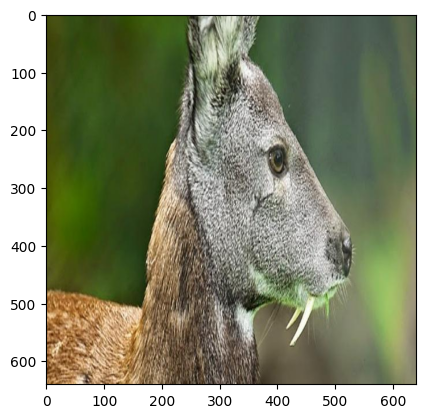

1 -------- 2


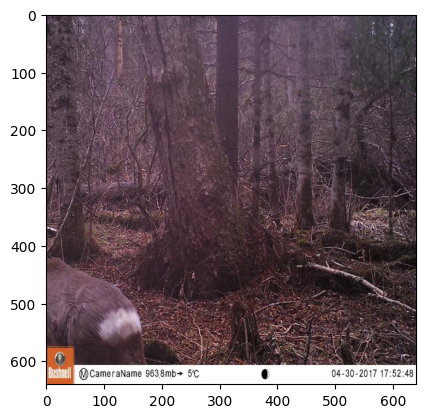

1 -------- 1


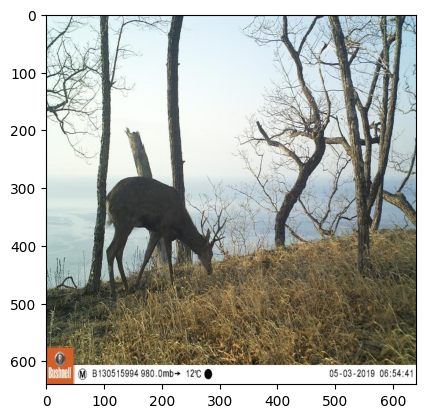

0 -------- 2


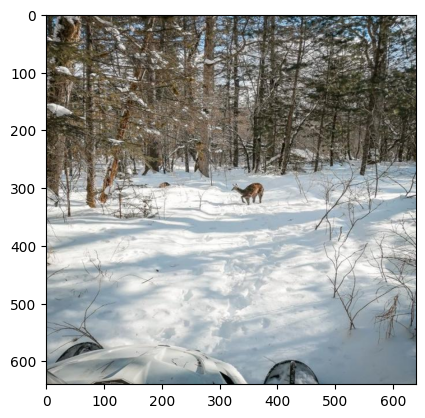

2 -------- 2


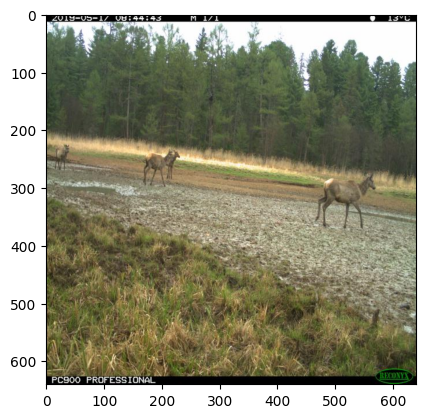

1 -------- 1


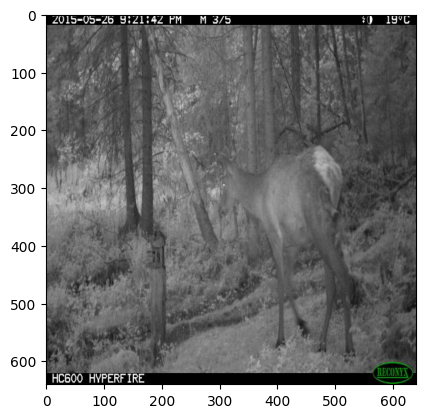

2 -------- 2


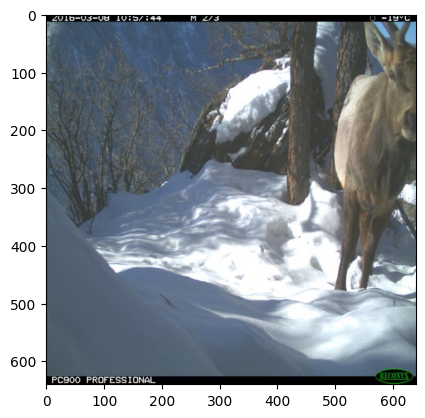

2 -------- 2


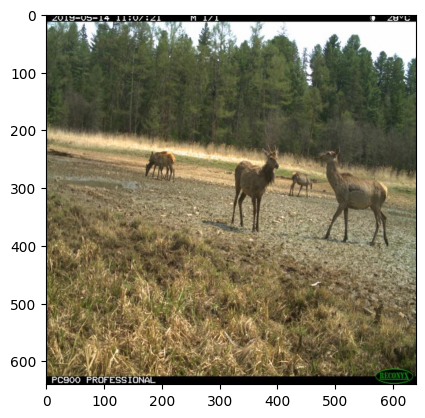

2 -------- 2


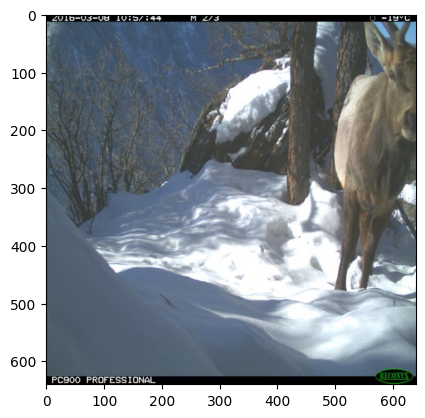

0 -------- 0


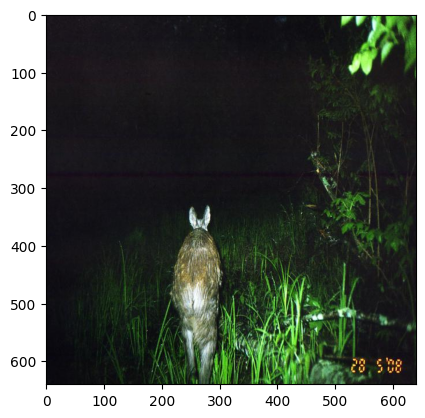

In [75]:
idx = np.random.randint(0, 248, 10) 

path = '/kaggle/input/parnokopit/test/'

for i in range(10):
    print(all_frame.loc[idx[i], 'true'], '--------', all_frame.loc[idx[i], 'pred_mean'])
    plt.imshow(Image.open(path + all_frame.loc[idx[i], 'filename']))
    plt.show()

# **Сохранение csv**

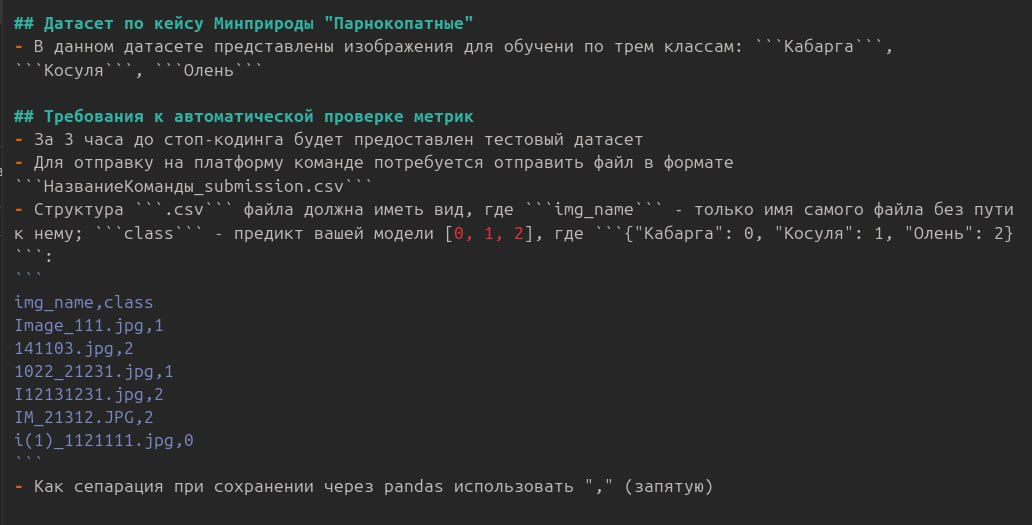


In [76]:
def make_csv(results):
    final_csv = pd.DataFrame()
    
    final_csv['img_name'] = results['path_vit'].map(lambda x: x.split('/')[-1])
    final_csv['class'] = results['pred_mean']
    
    return final_csv

In [77]:
final_csv = make_csv(res)

In [78]:
final_csv

,img_name,class
0,-__303_jpg.rf.ffe46fb4964dbfe40bc7360767bf51c3...,0
1,-8_JPG.rf.b80be696578ef91873887198679b34e5.jpg,0
2,Im_0002422_jpg.rf.b026a491e227e76439bd5d7f87a5...,2
3,tr64a_MuskDeer_20-05-2008_02_jpg.rf.8a535af85d...,2
4,Im_0005764_1_jpg.rf.87e9825f6e92c53ff1279599c6...,1
...,...,...
242,Im_0002319_jpg.rf.e9fd7e80600c9e3591d8931a611f...,1
243,Im_0002250_jpg.rf.c92cb5954d167ce60fd85320cb1b...,2
244,DSC_5129_JPG.rf.8c5cfd3562e19c3a403f5ecca56be3...,2
245,tr47_MuskDeer_30-04-2008_01_jpg.rf.cf7a430a82d...,1


In [79]:
final_csv.to_csv('MISISDarkhorse_submission.csv', index=False)